In [50]:
__file__ = 'A1.ipynb'
import sys
import pathlib
sys.path.append(str(pathlib.Path(__file__).absolute().parent.parent)+"/FP4_lib")
import functions as f
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from uncertainties import unumpy as up
from uncertainties import ufloat
import math as m
import scipy.constants as const
import lmfit

In [51]:
with open('Data/Aufg_5.4.txt','r') as tf:
    data = np.genfromtxt(tf).T
with open('Res/cp-cal_res.txt','r') as tf:
    cal = np.genfromtxt(tf).T
for i in range(len(data[1])):
    data[0][i]-= 729900


data = f.channel_to_pos(data,cal)

In [52]:
data[1] = data[1]*10
yerr = 0.035339825186025027*np.abs(data[1])
print(np.mean(data[2]))

0.030193000531300133


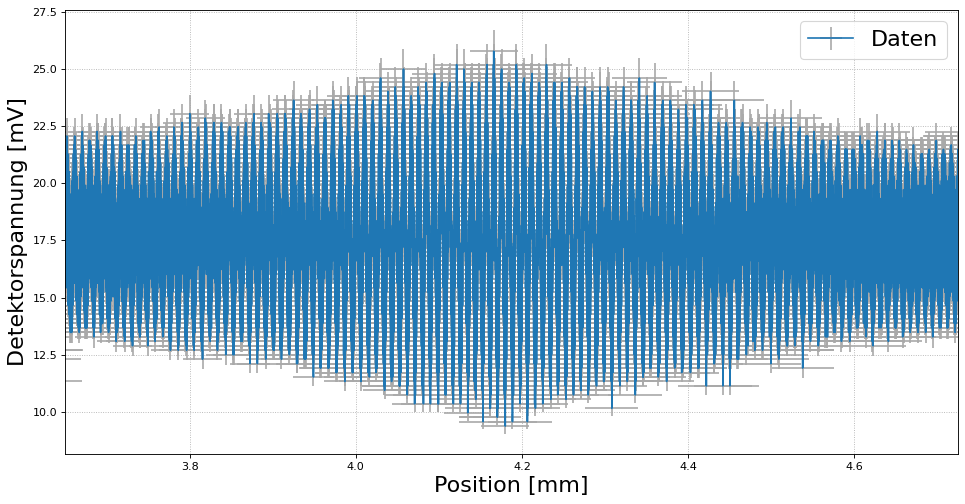

In [53]:
f.figsize(2)
plt.errorbar(data[0],data[1],yerr=yerr,xerr=data[2],label = 'Daten',ecolor='darkgray')

f.form([3.650,4.725],xlabel='Position [mm]',ylabel='Detektorspannung [mV]')

Wavelength: 3.688571126257906e-06 m


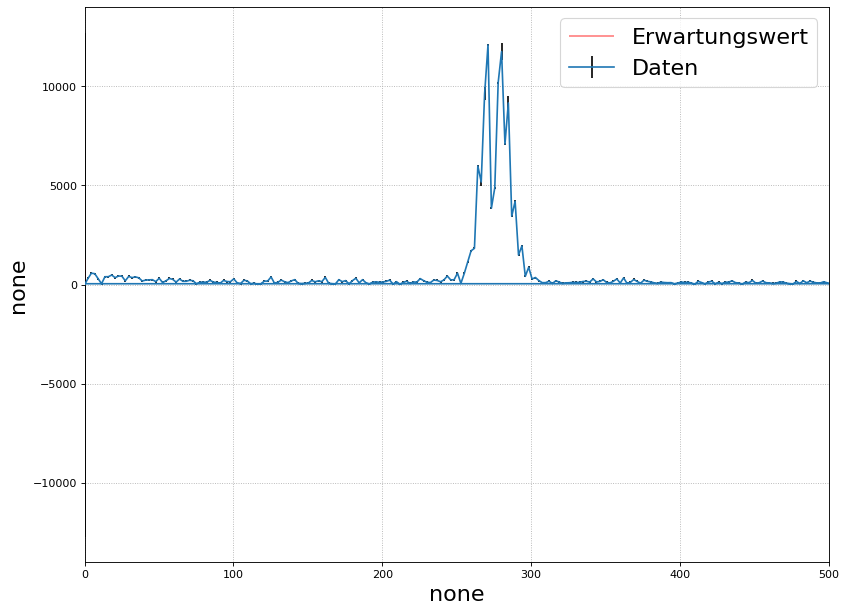

In [54]:
freq_scale = 2/5.127868608985219*1e-3

intensity = data[1]
position  = data[0]*freq_scale


intensity -= np.mean(intensity)


freqs = np.fft.fftfreq(len(intensity), d=((np.mean(np.diff(position)))))
fft_int = np.fft.fft(intensity)
fft_err = np.fft.fft(yerr).clip(5*10)

peak_idx = np.argmax(np.abs(fft_int))
peak_freq = freqs[peak_idx]


print(f"Wavelength: {1/peak_freq} m")

freqs = freqs*1e-3

f.figsize(1)

plt.errorbar(freqs, np.abs(fft_int),yerr=np.abs(fft_err),ecolor='k',zorder=10,label='Daten')
plt.xlim(0,500)
plt.vlines(3.6114e-06,0,1300,colors="r",zorder=5,alpha = 0.5,label='Erwartungswert')
f.form()

In [55]:
dat = [freqs, np.abs(fft_int),np.abs(fft_err)]

sorted_indices = sorted(range(len(dat[0])), key=lambda k: dat[0][k])

dat_sorted = [[dat[0][i], dat[1][i],dat[2][i]] for i in sorted_indices]

dat_sorted = np.array(dat_sorted).T

[[Model]]
    Model(ngaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 44
    # variables        = 2
    chi-square         = 171484.092
    reduced chi-square = 4082.95456
    Akaike info crit   = 367.794470
    Bayesian info crit = 371.362850
    R-squared          = 0.99967332
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    b:  at initial value
[[Variables]]
    a:  1.00000000 (init = 1)
    b:  1.00000000 (init = 1)


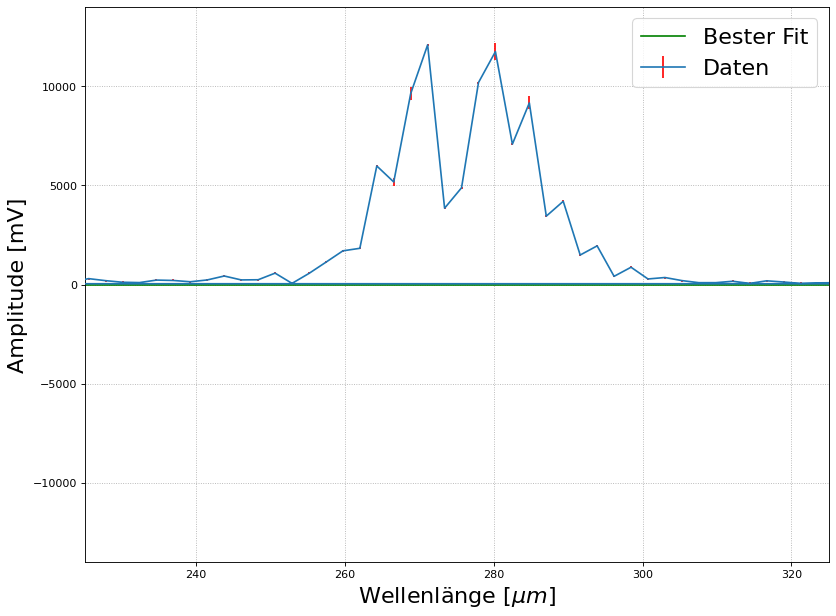

In [58]:
von,bis = f.pos(dat_sorted[0],225),f.pos(dat_sorted[0],325)

#res = f.gausfit(dat_sorted[1,von:bis],dat_sorted[0,von:bis],dat_sorted[2,von:bis])

def ngaus(x,a,b):
    return a/(2*np.sqrt(m.pi))*np.exp(-(((b-x)**2)*a**2)/(4))

model_func = lmfit.model.Model(ngaus)  

#parameter erstellen
pars_func = model_func.make_params()



pars_func["a"].set(value=1)#,min=0.01,max=1)
pars_func["b"].set(value=1)#,min=0.01,max=1)

#Fitten
res = model_func.fit(dat_sorted[1,von:bis],x=dat_sorted[0,von:bis],params=pars_func,weights=1/dat_sorted[2,von:bis],nan_policy='propagate')



print(res.fit_report())


f.figsize(1)

plt.errorbar(freqs, np.abs(fft_int),yerr=np.abs(fft_err),ecolor='r',zorder=10,label='Daten')
plt.plot(np.arange(0,400,1),res.eval(x=np.arange(0,400,1)),color='g',label='Bester Fit')
plt.xlim(225,325)
#plt.vlines(3.6381e-06,0,12500,colors="r",zorder=5,alpha = 0.5,label='Erwartungswert')
f.form(xlabel=f'Wellenlänge [$\mu m$]',ylabel='Amplitude [mV]')

In [57]:
#1/e breite
print('1/e Breite')
eb3 = ufloat(res.params["fwhm"].value,res.params["fwhm"].stderr)/ (2*np.log(2)**0.5)*2
print(eb3.format(':1.5'))
recipr = (1e-3/eb3).format(':1.5')
print(f'in reciproken micrometern:{recipr}$\mu m^-1$')
print('1/e höhe')
print(res.params['height'].value/m.e)
print('Kontrolle 1/e breite in fit eingesetzt')
print(res.eval(x=res.params['center'].value-eb3.n/2))

1/e Breite


KeyError: 'fwhm'